# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
!pip -q install ./python

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

# Build Solution

In [1]:
import os
import sys
import argparse
import logging
from collections import deque
import matplotlib.pyplot as plt
from ddpg_agent import Agent
from workspace_utils import active_session
import torch
import time
import random
import utils
from utils import Params
from utils import set_logger
from itertools import count

%matplotlib inline

In [3]:
def ddpg(experiment_name, agents, scores_episode,  scores_window, start_episode, episodes_step, params, train_mode=True):
    
    success = False
    max_t=1000
    random.seed(2)
    learn_exps = 0
    completed = 0

    scores = np.zeros(num_agents)

    for i_episode in range(start_episode, start_episode+episodes_step):
        env_info = env.reset(train_mode=train_mode)[brain_name]
        states = env_info.vector_observations

        for agent in agents:
            agent.reset(completed)

        scores = np.zeros(num_agents)
        l_time = time.time()

        for t in range(1, max_t):
            
            add_noise = True if completed < 90.0 else False         # don't add noise in once substatial experince

            #actions = [agents[i].act(states[i]) for i in range(num_agents)]
            actions = np.array([agents[i].act(states[i], add_noise) for i in range(num_agents)])
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done 

            #for i in range(num_agents):
            #    learn_exps = agents[i].step(t, states[i], actions[i], rewards[i], next_states[i], dones[i], completed, np.mean(scores_window)) 

            agents[0].add_memory(states, actions, rewards, next_states, dones)
            if t % params.time_steps == 0:
                for i in range(num_agents):
                    learn_exps = agents[i].sample_learning()

            states = next_states
            scores += rewards
            if t % params.time_steps == 0:
                print('\rTimestep {}\tScore: {:.2f}\tmin/max: {:.2f}/{:.2f} ({:.2f})\ttime: {:.2f}\tlearn: {}.{}/{} - {}'
                      .format(t, np.mean(scores), np.min(scores), np.max(scores), completed, time.time()-l_time, agent.batch_size, learn_exps, len(agent.memory), add_noise), end="") 
            if np.any(dones):
                break 
        score = np.mean(scores)
        scores_window.append(score)       # save most recent score
        scores_episode.append(score)

        completed = score * 100.0 / params.target_score  

        print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)), end="\n")
        if np.mean(scores_window)>=params.target_score:
            success = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            break
                
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor4.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic4.pth')
    torch.save(scores_episode, 'checkpoint_scores_episode4.pth')
    torch.save(scores_window, 'checkpoint_scores_window4.pth')
            
    return success, scores_episode

##################################################################################################################################


def plot(scores_episode):
    # plot the scores.

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores_episode)), scores_episode)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title("Ave mean scores")
    plt.show()

def list_params(params, json_path):

    logging.info("\rUsing hyperparameters from {}".format(json_path))
    for keys,values in params.__dict__.items():
        logging.info('\r\t {}\t: {}'.format(keys, values))
        

def run_model(experiment_name, train_mode, reload=False):

    if experiment_name == None:
        experiment_name = input("enter experiment name (eg 20Agents):")
        if experiment_name == "":
            experiment_name = "20Agents"
            
    if experiment_name == None:
        train_mode = input("Train/Eval:")
        if train_mode == "":
            train_mode = "Train,Eval"
    
    set_logger(experiment_name + ".log")

    print('Train Mode: ',train_mode)
    print('Number of agents:', num_agents)

    params = Params("data/params.json")
    list_params(params, "data/params.json")

    n_episodes = params.train_episodes
    episodes_step = 20

    scores_episode = []
    scores_window = deque(maxlen=100)
    agents = [] 

    if reload:
        for i in range(num_agents):
            agent = Agent(state_size, action_size, random_seed=2, params=params)
            agent.actor_local.load_state_dict(torch.load('checkpoint_actor2.pth'))
            agent.critic_local.load_state_dict(torch.load('checkpoint_critic2.pth'))   
            agents.append(agent)
            scores_episode = torch.load('checkpoint_scores_episode2.pth',map_location=torch.device('cpu'))
            scores_window = torch.load('checkpoint_scores_window2.pth',map_location=torch.device('cpu'))
    else:
        for i in range(num_agents):
            agents.append(Agent(state_size, action_size, random_seed=2, params=params))    

    ##################################################################################################################################

    start_episode = 181
    start_time = time.time()

    #with active_session():

    for i_episode in range(start_episode, n_episodes+1, episodes_step):
        
        if "Train" in train_mode:
            # Train the agent
            success, scores_episode = ddpg(experiment_name, agents, scores_episode,  scores_window, i_episode, episodes_step, params=params, train_mode=True)

        if "Eval" in train_mode:
            # Test 'Trained' Agent
            success, scores_episode = ddpg(experiment_name, agents, scores_episode,  scores_window, i_episode, episodes_step, params=params, train_mode=False)

        print('\rEpisode {}\ Score: {:.2f} in {:.2f}'.format(len(scores_episode), np.mean(scores_window), time.time()-start_time), end="\n")

        if success:
            break
    
    return scores_episode


In [5]:
with active_session():
    scores = run_model("20Agents","Train", reload=True)


Using hyperparameters from data/20Agents/params.json
	 experiment_name	: 20Agents
	 model_type	: DDPG
	 use_model	: False
	 num_agents	: 20
	 buffer_size	: 1000000.0
	 batch_size	: 64
	 gamma	: 0.99
	 time_steps	: 20
	 update_rate	: 10
	 target_tau	: 0.001
	 lr_actor	: 0.0001
	 lr_critic	: 0.0003
	 weight_decay	: 0.0001
	 dropout	: 0.2
	 mean_windowsize	: 100
	 t_max	: 500
	 target_score	: 30.0
	 train_episodes	: 1000
	 test_episodes	: 100


Train Mode:  Train
Number of agents: 20
load model: False


Episode 1	Average Score: 0.02	Elapse time: 17.77
Episode 2	Average Score: 0.02	Elapse time: 31.90
Episode 3	Average Score: 0.02	Elapse time: 32.16
Episode 4	Average Score: 0.02	Elapse time: 46.35
Episode 5	Average Score: 0.04	Elapse time: 60.45
Episode 6	Average Score: 0.05	Elapse time: 60.75
Episode 7	Average Score: 0.09	Elapse time: 76.05
Episode 8	Average Score: 0.17	Elapse time: 92.66
Episode 9	Average Score: 0.23	Elapse time: 93.01
Episode 10	Average Score: 0.30	Elapse time: 110.91
Episode 11	Average Score: 0.40	Elapse time: 128.31
Episode 12	Average Score: 0.48	Elapse time: 128.65
Episode 13	Average Score: 0.58	Elapse time: 145.64
Episode 14	Average Score: 0.69	Elapse time: 162.09
Episode 15	Average Score: 0.78	Elapse time: 162.40
Episode 16	Average Score: 0.89	Elapse time: 178.71
Episode 17	Average Score: 1.00	Elapse time: 193.77
Episode 18	Average Score: 1.10	Elapse time: 194.06
Episode 19	Average Score: 1.21	Elapse time: 208.51
Episode 20	Average Score: 1.32	Elapse time: 223.6

Episode 159	Average Score: 20.18	Elapse time: 1619.84
Episode 160	Average Score: 20.38	Elapse time: 1635.02
Episode 161	Average Score: 20.57	Elapse time: 1650.24
Episode 162	Average Score: 20.77	Elapse time: 1650.53
Episode 163	Average Score: 20.96	Elapse time: 1665.86
Episode 164	Average Score: 21.16	Elapse time: 1681.54
Episode 165	Average Score: 21.36	Elapse time: 1681.86
Episode 166	Average Score: 21.55	Elapse time: 1697.21
Episode 167	Average Score: 21.75	Elapse time: 1712.42
Episode 168	Average Score: 21.95	Elapse time: 1712.73
Episode 169	Average Score: 22.14	Elapse time: 1727.82
Episode 170	Average Score: 22.34	Elapse time: 1742.96
Episode 171	Average Score: 22.53	Elapse time: 1743.25
Episode 172	Average Score: 22.73	Elapse time: 1759.04
Episode 173	Average Score: 22.93	Elapse time: 1774.06
Episode 174	Average Score: 23.12	Elapse time: 1774.35
Episode 175	Average Score: 23.32	Elapse time: 1789.41
Episode 176	Average Score: 23.52	Elapse time: 1804.59
Episode 177	Average Score: 2

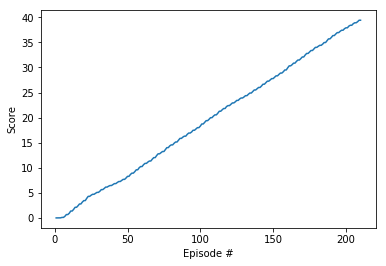

In [6]:
plot(scores)

In [ ]:
env.close()